In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'fr'
target_lang = 'en'
model_size = '7b'
prefix = "./data/langs/"
type = 'tuned-chinese'

In [4]:
# Parameters
model_size = "13b"
target_lang = "de"
input_lang = "de"
type = "logit"


In [5]:
df_en_input = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_target = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()
llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-{model_size}-hf",
                device_map={"": "cuda"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
    
latent="en"
if type == 'logit':
    llama_lens = LogitLens.from_model(llama).to("cuda")
    out_dir = f'./visuals/logit'
if type == 'tuned':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-{model_size}-hf").to("cuda")
    out_dir = f'./visuals/tuned'
if type == 'tuned-chinese':
    llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda")
    out_dir = f'./visuals/tuned-chinese'
    latent = 'zh'
    chinese = pd.read_csv(f'{prefix}zh/clean.csv').reindex()
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=5120, out_features=32000, bias=False)
)
U torch.Size([32000, 5120]) weights torch.Size([1, 5120])


0.11461826413869858


In [7]:
count = 0
for idx, word in enumerate(df_en_target['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_target)} are single tokens')

if input_lang == target_lang:
    df_en_target_input = df_en_target.copy()
    if latent == 'zh':
      chinese = chinese.loc[chinese["word_original"].isin(df_en_input["word_original"])]
      chinese.reset_index(drop=True, inplace=True)
      df_en_target_input['word_original'] = chinese['word_translation']
    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation': target_lang if target_lang != latent else f'{latent}_tgt'}, 
                                inplace=True)
    
else:
    df_en_target_input = df_en_target.merge(df_en_input, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    if latent == 'zh':
      chinese=chinese.loc[chinese["word_original"].isin(df_en_input["word_original"])]
      chinese.reset_index(drop=True, inplace=True)
    
      df_en_target_input['word_original'] = chinese['word_translation']

    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation_{target_lang}': target_lang if target_lang != latent else f'{latent}_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != latent else f'{latent}_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != latent:
    for i, row in df_en_target_input.iterrows():
        if row[latent].lower() in row[target_lang].lower():
            df_en_target_input.drop(i, inplace=True)

print(f'final length of df_en_{target_lang}_{input_lang}: {len(df_en_target_input)}')

for de 57 of 120 are single tokens
final length of df_en_de_de: 111


In [8]:
df_en_target_input

,lang,en,de,blank_prompt_original,blank_prompt_translation,blank_prompt_translation_masked,error
0,de,book,Buch,"A ""book"" is used to read stories. Answer: ""book"".","Ein ""Buch"" wird verwendet, um Geschichten zu l...","Ein ""___"" wird verwendet, um Geschichten zu le...",no error
1,de,cloud,Wolke,"A ""cloud"" is a visible mass of condensed water...","Eine ""Wolke"" ist eine sichtbare Masse aus kond...","Eine ""___"" ist eine sichtbare Masse aus konden...",no error
2,de,bag,Tasche,"A ""bag"" is used to carry items. Answer: ""bag"".","Eine ""Tasche"" wird zum Tragen von Gegenständen...","Eine ""___"" wird zum Tragen von Gegenständen ve...",no error
3,de,mouth,Mund,"A ""mouth"" is used to eat food and speak. Answe...","Ein ""Mund"" wird zum Essen und Sprechen benutzt...","Ein ""___"" wird zum Essen und Sprechen benutzt....",no error
4,de,soil,Boden,"""A ""soil"" is used for planting trees and crops...","""Ein ""Boden"" wird für die Anpflanzung von Bäum...","""Ein ""___"" wird für die Anpflanzung von Bäumen...",no error
...,...,...,...,...,...,...,...
115,de,office,Büro,"An ""office"" is a place where people usually do...","Ein ""Büro"" ist ein Ort, an dem Menschen normal...","Ein ""___"" ist ein Ort, an dem Menschen normale...",no error
116,de,rise,Anstieg,"""A ""rise"" is used to describe an increase or u...","""Ein ""Anstieg"" wird verwendet, um einen Anstie...","""Ein ""___"" wird verwendet, um einen Anstieg od...",no error
117,de,left,links,"'A ""left"" is a direction opposite to right. An...","Ein ""links"" ist eine Richtung, die der rechten...","Ein ""___"" ist eine Richtung, die der rechten e...",no error
118,de,power,Macht,"""A ""power"" is used to control or influence peo...","""Eine ""Macht"" wird benutzt, um Menschen oder D...","""Eine ""___"" wird benutzt, um Menschen oder Din...",no error


In [9]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [10]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent=latent):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, latent)
            intersection = set(out_token_id).intersection(set(latent_token_id))
            print(intersection)
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != latent and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [11]:
latent

'en'

In [12]:
dataset = []
for ind in tqdm(range(len(df_en_target_input))):
    d = next(sample(df_en_target_input, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                                       | 0/111 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                                                                             | 1/111 [00:00<00:19,  5.61it/s]

set()


  2%|███▋                                                                                                                                                                                                           | 2/111 [00:00<00:21,  5.05it/s]

  3%|█████▌                                                                                                                                                                                                         | 3/111 [00:00<00:21,  5.13it/s]

set()
set()


  4%|███████▍                                                                                                                                                                                                       | 4/111 [00:00<00:20,  5.19it/s]

  5%|█████████▎                                                                                                                                                                                                     | 5/111 [00:00<00:20,  5.18it/s]

set()
set()


  5%|███████████▏                                                                                                                                                                                                   | 6/111 [00:01<00:22,  4.67it/s]

  6%|█████████████                                                                                                                                                                                                  | 7/111 [00:01<00:21,  4.89it/s]

set()
set()


  7%|██████████████▉                                                                                                                                                                                                | 8/111 [00:01<00:20,  4.91it/s]

  8%|████████████████▊                                                                                                                                                                                              | 9/111 [00:01<00:19,  5.36it/s]

set()
set()


  9%|██████████████████▌                                                                                                                                                                                           | 10/111 [00:02<00:21,  4.78it/s]

set()


 10%|████████████████████▍                                                                                                                                                                                         | 11/111 [00:02<00:21,  4.65it/s]

 11%|██████████████████████▎                                                                                                                                                                                       | 12/111 [00:02<00:20,  4.86it/s]

set()
set()


 12%|████████████████████████▏                                                                                                                                                                                     | 13/111 [00:02<00:19,  5.00it/s]

set()


 13%|█████████████████████████▉                                                                                                                                                                                    | 14/111 [00:02<00:21,  4.60it/s]

set()


 14%|███████████████████████████▊                                                                                                                                                                                  | 15/111 [00:03<00:21,  4.40it/s]

set()
set()


 14%|█████████████████████████████▋                                                                                                                                                                                | 16/111 [00:03<00:20,  4.54it/s]

 15%|███████████████████████████████▌                                                                                                                                                                              | 17/111 [00:03<00:19,  4.72it/s]

set()


 16%|█████████████████████████████████▍                                                                                                                                                                            | 18/111 [00:03<00:20,  4.63it/s]

 17%|███████████████████████████████████▎                                                                                                                                                                          | 19/111 [00:03<00:19,  4.81it/s]

set()
set()


 18%|█████████████████████████████████████                                                                                                                                                                         | 20/111 [00:04<00:19,  4.77it/s]

 19%|██████████████████████████████████████▉                                                                                                                                                                       | 21/111 [00:04<00:18,  4.94it/s]

set()
set()


 20%|████████████████████████████████████████▊                                                                                                                                                                     | 22/111 [00:04<00:18,  4.94it/s]

 21%|██████████████████████████████████████████▋                                                                                                                                                                   | 23/111 [00:04<00:17,  5.13it/s]

set()
set()


 22%|████████████████████████████████████████████▌                                                                                                                                                                 | 24/111 [00:04<00:16,  5.32it/s]

 23%|██████████████████████████████████████████████▍                                                                                                                                                               | 25/111 [00:05<00:15,  5.69it/s]

set()
set()


 23%|████████████████████████████████████████████████▎                                                                                                                                                             | 26/111 [00:05<00:14,  5.72it/s]

set()


 24%|██████████████████████████████████████████████████                                                                                                                                                            | 27/111 [00:05<00:16,  5.14it/s]

 25%|███████████████████████████████████████████████████▉                                                                                                                                                          | 28/111 [00:05<00:16,  5.14it/s]

set()
set()


 26%|█████████████████████████████████████████████████████▊                                                                                                                                                        | 29/111 [00:05<00:15,  5.13it/s]

set()


 27%|███████████████████████████████████████████████████████▋                                                                                                                                                      | 30/111 [00:06<00:17,  4.64it/s]

set()


 28%|█████████████████████████████████████████████████████████▌                                                                                                                                                    | 31/111 [00:06<00:18,  4.24it/s]

 29%|███████████████████████████████████████████████████████████▍                                                                                                                                                  | 32/111 [00:06<00:17,  4.60it/s]

set()
set()


 30%|█████████████████████████████████████████████████████████████▏                                                                                                                                                | 33/111 [00:06<00:15,  5.06it/s]

 31%|███████████████████████████████████████████████████████████████                                                                                                                                               | 34/111 [00:06<00:15,  5.03it/s]

{364, 29878}
set()


 32%|████████████████████████████████████████████████████████████████▉                                                                                                                                             | 35/111 [00:07<00:15,  4.85it/s]

 32%|██████████████████████████████████████████████████████████████████▊                                                                                                                                           | 36/111 [00:07<00:13,  5.44it/s]

set()
set()


 33%|████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 37/111 [00:07<00:13,  5.63it/s]

 34%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 38/111 [00:07<00:12,  5.98it/s]

set()
set()


 35%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 39/111 [00:07<00:12,  5.66it/s]

 36%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 40/111 [00:07<00:12,  5.50it/s]

set()
set()


 37%|████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 41/111 [00:08<00:12,  5.73it/s]

 38%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 42/111 [00:08<00:11,  5.85it/s]

set()
set()


 39%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 43/111 [00:08<00:12,  5.57it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 44/111 [00:08<00:12,  5.44it/s]

set()
set()


 41%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 45/111 [00:08<00:11,  5.63it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 46/111 [00:09<00:11,  5.60it/s]

{29888, 285}
{269, 29879}


 42%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 47/111 [00:09<00:12,  5.20it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 48/111 [00:09<00:12,  5.15it/s]

{269, 29879}
set()


 44%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 49/111 [00:09<00:11,  5.34it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 50/111 [00:09<00:10,  5.66it/s]

{29876, 302}
set()


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 51/111 [00:09<00:10,  5.77it/s]

set()


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 52/111 [00:10<00:11,  5.01it/s]

set()


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 53/111 [00:10<00:12,  4.59it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 54/111 [00:10<00:11,  4.84it/s]

set()
set()


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 55/111 [00:10<00:10,  5.37it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 56/111 [00:10<00:10,  5.28it/s]

set()
set()


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 57/111 [00:11<00:12,  4.36it/s]

set()


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 58/111 [00:11<00:13,  4.04it/s]

set()


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 59/111 [00:11<00:13,  3.93it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 60/111 [00:12<00:11,  4.34it/s]

set()
set()


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 61/111 [00:12<00:11,  4.46it/s]

set()


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 62/111 [00:12<00:11,  4.23it/s]

{29873, 260}


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 63/111 [00:12<00:11,  4.27it/s]

set()


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 64/111 [00:13<00:11,  4.05it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 65/111 [00:13<00:10,  4.38it/s]

set()
set()


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 66/111 [00:13<00:10,  4.32it/s]

set()


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 67/111 [00:13<00:11,  3.93it/s]

set()


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 68/111 [00:13<00:10,  4.04it/s]

set()


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 69/111 [00:14<00:10,  4.08it/s]

set()


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 70/111 [00:14<00:10,  4.10it/s]

set()


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 71/111 [00:14<00:09,  4.27it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 72/111 [00:14<00:08,  4.64it/s]

set()
set()


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 73/111 [00:15<00:08,  4.56it/s]

set()


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 74/111 [00:15<00:08,  4.38it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 75/111 [00:15<00:07,  4.60it/s]

set()
set()


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 76/111 [00:15<00:08,  4.30it/s]

set()


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/111 [00:15<00:07,  4.40it/s]

set()


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/111 [00:16<00:07,  4.39it/s]

set()


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 79/111 [00:16<00:07,  4.14it/s]

set()


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 80/111 [00:16<00:07,  4.15it/s]

set()


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 81/111 [00:16<00:07,  4.22it/s]

set()


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 82/111 [00:17<00:07,  4.05it/s]

set()


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 83/111 [00:17<00:07,  3.77it/s]

set()


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 84/111 [00:17<00:06,  4.04it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 85/111 [00:17<00:05,  4.44it/s]

set()
set()


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 86/111 [00:18<00:06,  3.92it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 87/111 [00:18<00:05,  4.21it/s]

set()
set()


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 88/111 [00:18<00:05,  4.19it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 89/111 [00:18<00:04,  4.42it/s]

set()
set()


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 90/111 [00:19<00:04,  4.38it/s]

set()


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 91/111 [00:19<00:04,  4.49it/s]

set()


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 92/111 [00:19<00:04,  4.57it/s]

set()


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 93/111 [00:19<00:04,  4.17it/s]

set()


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 94/111 [00:20<00:04,  3.65it/s]

set()


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 95/111 [00:20<00:04,  3.87it/s]

set()


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 96/111 [00:20<00:03,  3.82it/s]

set()


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 97/111 [00:20<00:03,  3.70it/s]

set()


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 98/111 [00:21<00:03,  3.92it/s]

set()


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 99/111 [00:21<00:02,  4.01it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 100/111 [00:21<00:02,  4.31it/s]

set()
set()


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 101/111 [00:21<00:02,  4.43it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 102/111 [00:22<00:01,  4.60it/s]

set()
set()


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 103/111 [00:22<00:01,  4.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 104/111 [00:22<00:01,  5.14it/s]

set()
set()


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 105/111 [00:22<00:01,  4.40it/s]

set()


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 106/111 [00:22<00:01,  4.04it/s]

set()


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 107/111 [00:23<00:00,  4.23it/s]

set()


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 108/111 [00:23<00:00,  4.31it/s]

set()


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 109/111 [00:23<00:00,  4.32it/s]

{29880, 301}


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 110/111 [00:23<00:00,  4.28it/s]

set()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111/111 [00:24<00:00,  4.15it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111/111 [00:24<00:00,  4.60it/s]

set()


In [13]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [14]:
df

,prompt,out_token_id,out_token_str,latent_token_id,latent_token_str,in_token_str
0,"Deutsch: ""löschen"" - Deutsch: ""löschen""\nDeuts...","[3727, 10586, 29933, 22987, 5373, 350]",Buch,"[3143, 29890, 289, 833, 2909, 1045]",book,Buch
1,"Deutsch: ""Lied"" - Deutsch: ""Lied""\nDeutsch: ""F...","[399, 14962, 29956, 11902]",Wolke,"[9274, 1067, 695, 9570, 274, 17184, 29883, 236...",cloud,Wolke
2,"Deutsch: ""Gitter"" - Deutsch: ""Gitter""\nDeutsch...","[23793, 323, 10523, 29911]",Tasche,"[29890, 9922, 19548, 23156, 289, 2291]",bag,Tasche
3,"Deutsch: ""Sprache"" - Deutsch: ""Sprache""\nDeuts...","[8229, 341, 13564, 29924]",Mund,"[29885, 2730, 21026, 4346, 29442, 286, 13394]",mouth,Mund
4,"Deutsch: ""sieben"" - Deutsch: ""sieben""\nDeutsch...","[8431, 29933, 1952, 350, 19929]",Boden,"[269, 29879, 22473, 578, 577]",soil,Boden
...,...,...,...,...,...,...
99,"Deutsch: ""Freund"" - Deutsch: ""Freund""\nDeutsch...","[29909, 24650, 1976, 319, 4920]",Abschnitt,"[8803, 269, 4004, 5226, 21149, 29879, 3471, 40...",section,Abschnitt
100,"Deutsch: ""Punkt"" - Deutsch: ""Punkt""\nDeutsch: ...","[29933, 16144, 350, 15455]",Büro,"[20205, 29877, 2696, 3344, 288, 1283, 974, 803...",office,Büro
101,"Deutsch: ""Tag"" - Deutsch: ""Tag""\nDeutsch: ""Gem...","[29909, 530, 21877, 319, 2744]",Anstieg,"[364, 5161, 10107, 3780, 374, 29878, 14451]",rise,Anstieg
102,"Deutsch: ""Schule"" - Deutsch: ""Schule""\nDeutsch...","[21870, 4326, 3219, 341, 29924, 15735, 17197]",Macht,"[4764, 282, 13519, 12248, 772, 29886, 1129, 3081]",power,Macht


In [15]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    tensors=[]
    for i in range(len(model.model.layers)):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hidden_states).squeeze(1).detach().cpu()
    return tensors,hidden_states
        

In [16]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:00,  1.07it/s]

2it [00:01,  1.93it/s]

3it [00:01,  2.49it/s]

4it [00:01,  2.74it/s]

5it [00:01,  3.05it/s]

6it [00:02,  3.28it/s]

7it [00:02,  3.33it/s]

8it [00:02,  3.59it/s]

9it [00:03,  3.82it/s]

10it [00:03,  3.89it/s]

11it [00:03,  3.83it/s]

12it [00:03,  3.94it/s]

13it [00:04,  3.88it/s]

14it [00:04,  4.07it/s]

15it [00:04,  4.18it/s]

16it [00:04,  4.13it/s]

17it [00:04,  4.13it/s]

18it [00:05,  3.82it/s]

19it [00:05,  3.77it/s]

20it [00:05,  3.90it/s]

21it [00:06,  3.93it/s]

22it [00:06,  4.02it/s]

23it [00:06,  4.26it/s]

24it [00:06,  4.45it/s]

25it [00:06,  4.65it/s]

26it [00:07,  4.57it/s]

27it [00:07,  4.60it/s]

28it [00:07,  4.59it/s]

29it [00:07,  4.45it/s]

30it [00:07,  4.47it/s]

31it [00:08,  4.50it/s]

32it [00:08,  4.60it/s]

33it [00:08,  4.64it/s]

34it [00:08,  4.44it/s]

35it [00:09,  4.19it/s]

36it [00:09,  4.17it/s]

37it [00:09,  3.91it/s]

38it [00:09,  4.10it/s]

39it [00:10,  4.29it/s]

40it [00:10,  4.45it/s]

41it [00:10,  4.54it/s]

42it [00:10,  4.52it/s]

43it [00:10,  4.41it/s]

44it [00:11,  4.45it/s]

45it [00:11,  4.46it/s]

46it [00:11,  4.32it/s]

47it [00:11,  4.15it/s]

48it [00:12,  4.12it/s]

49it [00:12,  4.05it/s]

50it [00:12,  4.14it/s]

51it [00:12,  4.22it/s]

52it [00:13,  4.18it/s]

53it [00:13,  4.41it/s]

54it [00:13,  4.48it/s]

55it [00:13,  4.46it/s]

56it [00:14,  4.24it/s]

57it [00:14,  4.41it/s]

58it [00:14,  4.01it/s]

59it [00:14,  4.06it/s]

60it [00:15,  4.14it/s]

61it [00:15,  4.08it/s]

62it [00:15,  4.10it/s]

63it [00:15,  4.08it/s]

64it [00:15,  4.14it/s]

65it [00:16,  4.19it/s]

66it [00:16,  4.26it/s]

67it [00:16,  4.25it/s]

68it [00:16,  4.21it/s]

69it [00:17,  4.18it/s]

70it [00:17,  4.30it/s]

71it [00:17,  4.21it/s]

72it [00:17,  4.15it/s]

73it [00:18,  4.17it/s]

74it [00:18,  4.28it/s]

75it [00:18,  4.10it/s]

76it [00:18,  4.12it/s]

77it [00:19,  4.24it/s]

78it [00:19,  4.37it/s]

79it [00:19,  4.62it/s]

80it [00:19,  4.59it/s]

81it [00:19,  4.63it/s]

82it [00:20,  4.85it/s]

83it [00:20,  5.02it/s]

84it [00:20,  4.73it/s]

85it [00:20,  4.51it/s]

86it [00:20,  4.50it/s]

87it [00:21,  4.35it/s]

88it [00:21,  4.37it/s]

89it [00:21,  4.48it/s]

90it [00:21,  4.34it/s]

91it [00:22,  4.28it/s]

92it [00:22,  4.36it/s]

93it [00:22,  4.58it/s]

94it [00:22,  4.76it/s]

95it [00:22,  4.92it/s]

96it [00:23,  5.08it/s]

97it [00:23,  5.06it/s]

98it [00:23,  5.02it/s]

99it [00:23,  4.77it/s]

100it [00:23,  4.58it/s]

101it [00:24,  4.40it/s]

102it [00:24,  4.51it/s]

103it [00:24,  4.27it/s]

104it [00:24,  4.44it/s]

104it [00:24,  4.17it/s]

/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


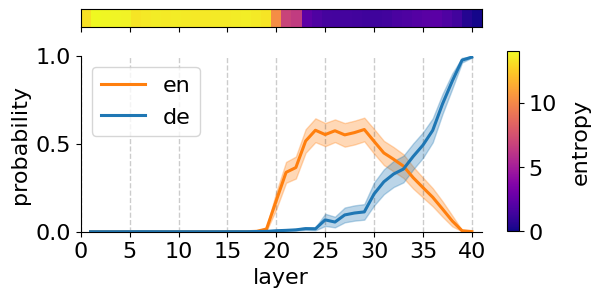

In [17]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, latent, color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.jpg', dpi=300, bbox_inches='tight')

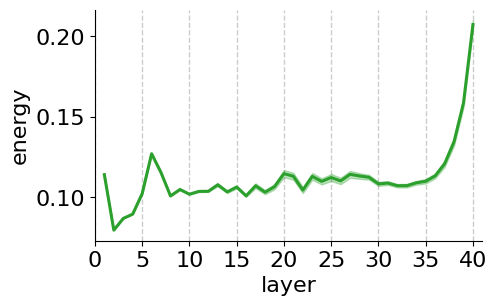

In [18]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.jpg', dpi=300, bbox_inches='tight')